In [1]:
import torch
import ChemSurrogate.data_processing as dp
import numpy as np
import gc
import numpy as np
import faiss
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


species_of_interest = ["H", "H2", "O", "C", "N", "SPlus", "MG", "SIPlus", "CL", "CPlus", "BULK_CO", "BULK_H", "E_minus", "CO", "BULK_CO"]

In [13]:
training_t, training_indices = dp.load_tensors_from_hdf5(category="training")
training_t = training_t[:, 1:-12]
training_t[:, 6:] = torch.pow(10, 20*training_t[:, 6:]-20)

validation_t, validation_indices = dp.load_tensors_from_hdf5(category="validation")
validation_t = validation_t[:, 1:-12]
validation_t[:, 6:] = torch.pow(10, 20*validation_t[:, 6:]-20)

del validation_indices, training_indices
gc.collect()

477

In [22]:
timestep = 80 * 1000

mask1 = training_t[:, 1] == timestep
mask2 = validation_t[:, 1] == timestep

training = training_t[mask1][:, 2:]
validation = validation_t[mask2][:, 2:]

training_np = training.cpu().numpy().astype('float32')
validation_np = validation.cpu().numpy().astype('float32')

physical_params_train = training_np[:, :4]
features_train = training_np[:, 4:]

physical_params_val = validation_np[:, :4]
features_val = validation_np[:, 4:]

start_time = time.time()
index = faiss.IndexFlatL2(4)
index.add(physical_params_train)
indexing_time = time.time() - start_time
print(f"Time to build index: {indexing_time:.6f} seconds")

start_time = time.time()
distances, indices = index.search(physical_params_val, k=1)
search_time = time.time() - start_time
print(f"Time to search all validation samples: {search_time:.6f} seconds")
print(f"Average time per query: {search_time/len(validation_np):.6f} seconds")

mpe_list = []
for i in range(len(validation_np)):
    nn_idx = indices[i][0]
    nn_features = features_train[nn_idx]
    actual_features = features_val[i]
    
    epsilon = 1e-10
    percentage_errors = np.abs((nn_features - actual_features) / (actual_features + epsilon)) * 100
    
    mpe = np.mean(percentage_errors)
    mpe_list.append(mpe)
    
average_mpe = np.mean(mpe_list)
print(f"\nAverage mean percentage error between validation features and nearest neighbor features: {average_mpe:.6f}%")


Time to build index: 0.000000 seconds
Time to search all validation samples: 0.017242 seconds
Average time per query: 0.000001 seconds

Average mean percentage error between validation features and nearest neighbor features: 146.953781%


Timestep 1000: Average MPE = 251.081848%
Timestep 2000: Average MPE = 231.059357%
Timestep 3000: Average MPE = 680.524597%
Timestep 4000: Average MPE = 510.628906%
Timestep 5000: Average MPE = 977.486084%
Timestep 6000: Average MPE = 619.271973%
Timestep 7000: Average MPE = 365.054382%
Timestep 8000: Average MPE = 239.620819%
Timestep 9000: Average MPE = 195.246307%
Timestep 10000: Average MPE = 198.178787%
Timestep 11000: Average MPE = 267.092499%
Timestep 12000: Average MPE = 222.204880%
Timestep 13000: Average MPE = 183.324249%
Timestep 14000: Average MPE = 174.841293%
Timestep 15000: Average MPE = 254.913498%
Timestep 16000: Average MPE = 208.607849%
Timestep 17000: Average MPE = 186.961578%
Timestep 18000: Average MPE = 173.819031%
Timestep 19000: Average MPE = 171.879807%
Timestep 20000: Average MPE = 164.431625%
Timestep 21000: Average MPE = 148.421829%
Timestep 22000: Average MPE = 152.242737%
Timestep 23000: Average MPE = 148.889771%
Timestep 24000: Average MPE = 146.975555%
T

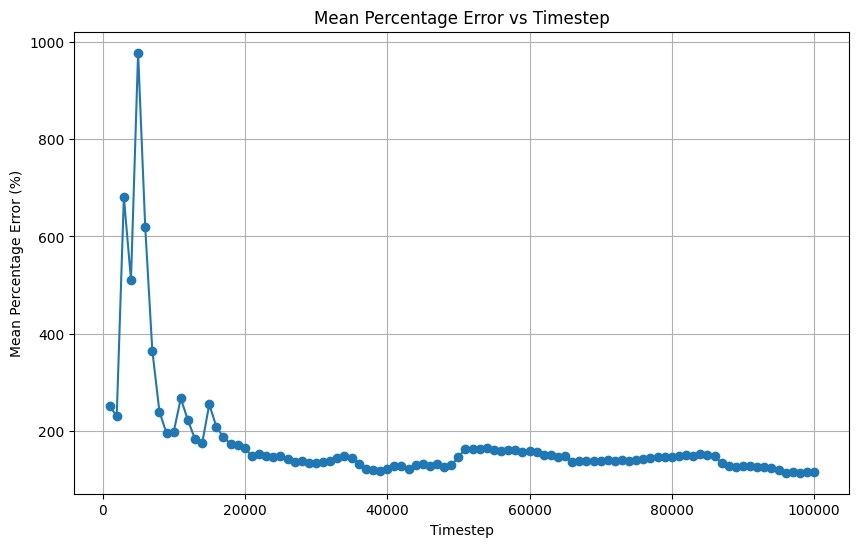

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import faiss
import time

timesteps = np.arange(1, 101) * 1000  # timesteps from 1000 to 100000
mpe_results = []

for timestep in timesteps:
    mask1 = training_t[:, 1] == timestep
    mask2 = validation_t[:, 1] == timestep
    
    training = training_t[mask1][:, 2:]
    validation = validation_t[mask2][:, 2:]
    
    training_np = training.cpu().numpy().astype('float32')
    validation_np = validation.cpu().numpy().astype('float32')
    
    physical_params_train = training_np[:, :4]
    features_train = training_np[:, 4:]
    
    physical_params_val = validation_np[:, :4]
    features_val = validation_np[:, 4:]
    
    index = faiss.IndexFlatL2(4)
    index.add(physical_params_train)
    
    distances, indices = index.search(physical_params_val, k=1)
    
    mpe_list = []
    for i in range(len(validation_np)):
        nn_idx = indices[i][0]
        nn_features = features_train[nn_idx]
        actual_features = features_val[i]
        
        epsilon = 1e-10
        percentage_errors = np.abs((nn_features - actual_features) / (actual_features + epsilon)) * 100
        
        mpe = np.mean(percentage_errors)
        mpe_list.append(mpe)
    
    average_mpe = np.mean(mpe_list)
    mpe_results.append(average_mpe)
    print(f"Timestep {timestep}: Average MPE = {average_mpe:.6f}%")

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(timesteps, mpe_results, marker='o')
plt.xlabel('Timestep')
plt.ylabel('Mean Percentage Error (%)')
plt.title('Abundances Percentage Error vs Timestep')
plt.grid(True)
plt.show()